## 使用座標作為Input data，(all keyframe)，進行BorderlineSMOTE，使用LSTM/GRU？作為模型。

## Import package

In [3]:
import numpy as np
import pandas as pd
import os
import math
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from natsort import natsorted
import cv2
from cv2 import imread, IMREAD_GRAYSCALE
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPool2D, Input, Dropout, LSTM, Dense, BatchNormalization, Activation, Reshape
from tensorflow.keras.layers import DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Bidirectional, concatenate, Flatten
from tensorflow.keras.constraints import max_norm
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from time import time
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE,BorderlineSMOTE,ADASYN
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Masking, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.layers import GRU, Dense, Masking, TimeDistributed, ConvLSTM1D, ConvLSTM2D
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp

### Read data

In [5]:
data_folder_path = 'D:\\111064555\\Work\\code\\datasets\\data_batch_lstm'

folder_names = [f for f in os.listdir(data_folder_path) if os.path.isdir(os.path.join(data_folder_path, f))]
folder_names = natsorted(folder_names)

# 計算每個資料夾中的圖片數量
video_lengths = []
for folder in folder_names:
    folder_path = os.path.join(data_folder_path, folder)
    num_images = len([img for img in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, img))])
    video_lengths.append(num_images)

print("Video lengths:", video_lengths)

Video lengths: [157, 162, 176, 223, 153, 157, 158, 187, 159, 168, 144, 148, 139, 136, 86, 124, 125, 124, 148, 168, 152, 152, 154, 191, 186, 183, 102, 144, 144, 144, 159, 107, 133, 135, 129, 57, 47, 59, 35, 48, 50, 56, 46, 47, 47, 54, 50, 43, 46, 56, 43, 53, 51, 53, 86, 61, 55, 61, 52, 39, 52, 58, 48, 50, 52, 90, 69, 52, 95, 66, 53, 61, 49, 50, 56, 68, 49, 51, 50, 77, 51, 52, 49, 31, 51, 48, 49, 54, 64, 56, 51, 62, 95, 68, 75, 72, 56, 58, 55, 117, 72, 62, 74, 58, 66, 56, 85, 59, 64, 50, 83, 60, 72, 44, 41, 56, 54, 56, 56, 89, 58, 60, 58, 86, 68, 67, 52, 41, 67, 61, 64, 51, 86, 64, 69, 65, 100, 70, 76, 57, 48, 72, 77, 76, 61, 233, 153, 162, 256, 185, 127, 228, 216, 107, 191, 142, 128, 164, 143, 143, 88, 169, 154, 153, 216, 263, 127, 159, 150, 191, 153, 132, 122, 106, 111, 157, 117, 142, 122, 110, 222, 138, 137, 108, 164, 132, 127, 98, 302, 174, 115, 74, 117, 126, 106, 153, 90, 80, 81, 196, 169, 179, 106, 127, 143, 76, 180, 127, 137, 92, 122, 134, 145, 147, 217, 175, 175, 138, 105, 114, 7

Class=0, n=39402 (97.501%)
Class=1, n=334 (0.826%)
Class=2, n=338 (0.836%)
Class=3, n=338 (0.836%)


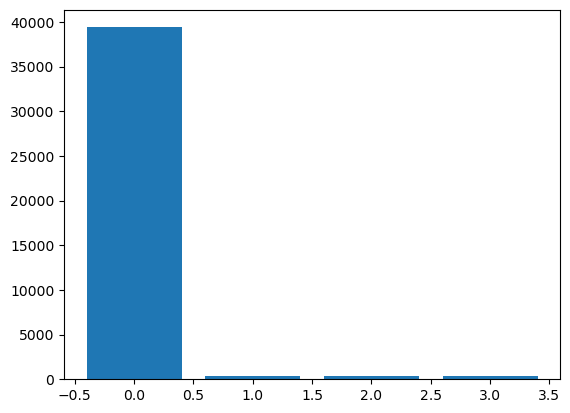

In [6]:
# Preprocess data_x
ds_x = pd.read_csv(r'D:\\111064555\\Work\\code\\Coordinate\\coordinates_list.csv')
ds_y = pd.read_csv(r'D:\\111064555\\Work\\code\\Coordinate\\label_all_keyframe_true.csv')

data_x = ds_x['coordinate'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ', dtype=np.float64))
data_x = np.stack(data_x.values)

# Preprocess labels
data_y = LabelEncoder().fit_transform(ds_y['keyframe'])
counter = Counter(data_y)
for k, v in counter.items():
    per = v / len(data_y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [7]:
## Split dataset
num_classes = 4

# Create video segments
videos = []
labels = []
start = 0
for length in video_lengths:
    end = start + length
    videos.append(data_x[start:end])
    labels.append(data_y[start:end])
    start = end

# Ensure each video segment is a 2D array and each label segment is a 1D array
videos = [np.array(video) for video in videos]
labels = [np.array(label) for label in labels]

# Find the maximum length of the video segments
max_length = max(video_lengths)

# Pad video segments
padded_videos = pad_sequences(videos, maxlen=max_length, dtype='float64', padding='post', value=0.0)
# Pad label segments
padded_labels = pad_sequences(labels, maxlen=max_length, dtype='int32', padding='post', value=-1)  # Use -1 as padding value for labels

# Mask and one-hot encode the labels
masked_labels = []
for label_seq in padded_labels:
    mask = label_seq != -1  # Create mask for valid labels
    one_hot_labels = to_categorical(label_seq, num_classes=num_classes)
    one_hot_labels[~mask] = 0  # Set padding positions to 0
    masked_labels.append(one_hot_labels)
padded_labels = np.array(masked_labels)

# Split data into training and validation sets
train_videos, temp_videos, y_train, y_temp = train_test_split(padded_videos, padded_labels, test_size=0.2, random_state=42, shuffle=False)
val_videos, test_videos, y_val, y_test = train_test_split(temp_videos, y_temp, test_size=0.5, random_state=42, shuffle=False)

"""
# Check shapes of the split data
print(f"Train videos shape: {train_videos.shape}")
print(f"Validation videos shape: {val_videos.shape}")
print(f"Test videos shape: {test_videos.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")
"""

Train videos shape: (270, 312, 45)
Validation videos shape: (34, 312, 45)
Test videos shape: (34, 312, 45)
y_train shape: (270, 312, 4)
y_val shape: (34, 312, 4)
y_test shape: (34, 312, 4)


In [8]:
# Calculate samples' weight
def data_generator(videos, labels, batch_size, class_weights):
    num_samples = videos.shape[0] # Get the numbers of samples
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_videos = videos[offset:offset+batch_size] # Get video
            batch_labels = labels[offset:offset+batch_size] # Get label

            batch_weights = np.zeros(batch_labels.shape[:2])
            for i in range(batch_labels.shape[0]):
                for j in range(batch_labels.shape[1]):
                    if not np.all(batch_labels[i, j] == 0):  # 忽略 padding
                        batch_weights[i, j] = class_weights[np.argmax(batch_labels[i, j])]
            
            yield batch_videos, batch_labels, batch_weights # yield: return multiple values

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_9 (Masking)         (None, 312, 45)           0         
                                                                 
 lstm_15 (LSTM)              (None, 312, 128)          89088     
                                                                 
 dropout_9 (Dropout)         (None, 312, 128)          0         
                                                                 
 lstm_16 (LSTM)              (None, 312, 64)           49408     
                                                                 
 lstm_17 (LSTM)              (None, 312, 32)           12416     
                                                                 
 dense_9 (Dense)             (None, 312, 4)            132       
                                                                 
Total params: 151,044
Trainable params: 151,044
Non-t

Epoch 33/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2927 - accuracy: 0.0084 - roc_auc: 0.0379 - pr_auc: 0.1380 - val_loss: 4.3426 - val_accuracy: 0.0066 - val_roc_auc: 0.0384 - val_pr_auc: 0.1379
Epoch 34/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2935 - accuracy: 0.0083 - roc_auc: 0.0384 - pr_auc: 0.1380 - val_loss: 4.3425 - val_accuracy: 0.0066 - val_roc_auc: 0.0384 - val_pr_auc: 0.1379
Epoch 35/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2930 - accuracy: 0.0083 - roc_auc: 0.0384 - pr_auc: 0.1380 - val_loss: 4.3424 - val_accuracy: 0.0066 - val_roc_auc: 0.0383 - val_pr_auc: 0.1378
Epoch 36/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2788 - accuracy: 0.0095 - roc_auc: 0.0434 - pr_auc: 0.1383 - val_loss: 4.3423 - val_accuracy: 0.0066 - val_roc_auc: 0.0382 - val_pr_auc: 0.1378
Epoch 37/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2811 - accuracy: 0.0091 - roc_auc: 0.0384 - 

8/8 [==============================] - 0s 42ms/step - loss: 4.2867 - accuracy: 0.0084 - roc_auc: 0.0333 - pr_auc: 0.1378 - val_loss: 4.3360 - val_accuracy: 0.0068 - val_roc_auc: 0.0323 - val_pr_auc: 0.1377
Epoch 108/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2717 - accuracy: 0.0095 - roc_auc: 0.0371 - pr_auc: 0.1380 - val_loss: 4.3359 - val_accuracy: 0.0068 - val_roc_auc: 0.0323 - val_pr_auc: 0.1377
Epoch 109/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2758 - accuracy: 0.0091 - roc_auc: 0.0335 - pr_auc: 0.1379 - val_loss: 4.3358 - val_accuracy: 0.0068 - val_roc_auc: 0.0322 - val_pr_auc: 0.1377
Epoch 110/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.2743 - accuracy: 0.0091 - roc_auc: 0.0368 - pr_auc: 0.1380 - val_loss: 4.3357 - val_accuracy: 0.0068 - val_roc_auc: 0.0322 - val_pr_auc: 0.1377
Epoch 111/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.2742 - accuracy: 0.0092 - roc_auc: 0.0367 - pr_auc: 0.

8/8 [==============================] - 0s 41ms/step - loss: 4.2683 - accuracy: 0.0091 - roc_auc: 0.0303 - pr_auc: 0.1378 - val_loss: 4.3296 - val_accuracy: 0.0070 - val_roc_auc: 0.0277 - val_pr_auc: 0.1375
Epoch 182/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2678 - accuracy: 0.0094 - roc_auc: 0.0326 - pr_auc: 0.1379 - val_loss: 4.3295 - val_accuracy: 0.0070 - val_roc_auc: 0.0276 - val_pr_auc: 0.1375
Epoch 183/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.2678 - accuracy: 0.0095 - roc_auc: 0.0326 - pr_auc: 0.1379 - val_loss: 4.3294 - val_accuracy: 0.0070 - val_roc_auc: 0.0276 - val_pr_auc: 0.1375
Epoch 184/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2655 - accuracy: 0.0094 - roc_auc: 0.0323 - pr_auc: 0.1379 - val_loss: 4.3293 - val_accuracy: 0.0070 - val_roc_auc: 0.0275 - val_pr_auc: 0.1375
Epoch 185/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2735 - accuracy: 0.0093 - roc_auc: 0.0306 - pr_auc: 0.

8/8 [==============================] - 0s 43ms/step - loss: 4.2614 - accuracy: 0.0096 - roc_auc: 0.0298 - pr_auc: 0.1378 - val_loss: 4.3234 - val_accuracy: 0.0072 - val_roc_auc: 0.0238 - val_pr_auc: 0.1374
Epoch 256/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2593 - accuracy: 0.0097 - roc_auc: 0.0297 - pr_auc: 0.1378 - val_loss: 4.3233 - val_accuracy: 0.0072 - val_roc_auc: 0.0238 - val_pr_auc: 0.1375
Epoch 257/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2666 - accuracy: 0.0095 - roc_auc: 0.0284 - pr_auc: 0.1378 - val_loss: 4.3233 - val_accuracy: 0.0072 - val_roc_auc: 0.0238 - val_pr_auc: 0.1375
Epoch 258/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2725 - accuracy: 0.0090 - roc_auc: 0.0268 - pr_auc: 0.1377 - val_loss: 4.3232 - val_accuracy: 0.0072 - val_roc_auc: 0.0237 - val_pr_auc: 0.1374
Epoch 259/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2737 - accuracy: 0.0090 - roc_auc: 0.0267 - pr_auc: 0.

8/8 [==============================] - 0s 42ms/step - loss: 4.2609 - accuracy: 0.0103 - roc_auc: 0.0265 - pr_auc: 0.1377 - val_loss: 4.3175 - val_accuracy: 0.0082 - val_roc_auc: 0.0213 - val_pr_auc: 0.1374
Epoch 330/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2670 - accuracy: 0.0102 - roc_auc: 0.0250 - pr_auc: 0.1376 - val_loss: 4.3174 - val_accuracy: 0.0082 - val_roc_auc: 0.0212 - val_pr_auc: 0.1374
Epoch 331/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2680 - accuracy: 0.0096 - roc_auc: 0.0248 - pr_auc: 0.1376 - val_loss: 4.3174 - val_accuracy: 0.0082 - val_roc_auc: 0.0212 - val_pr_auc: 0.1374
Epoch 332/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2675 - accuracy: 0.0097 - roc_auc: 0.0250 - pr_auc: 0.1376 - val_loss: 4.3173 - val_accuracy: 0.0082 - val_roc_auc: 0.0212 - val_pr_auc: 0.1374
Epoch 333/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2525 - accuracy: 0.0108 - roc_auc: 0.0272 - pr_auc: 0.

8/8 [==============================] - 0s 40ms/step - loss: 4.2619 - accuracy: 0.0113 - roc_auc: 0.0236 - pr_auc: 0.1376 - val_loss: 4.3119 - val_accuracy: 0.0086 - val_roc_auc: 0.0192 - val_pr_auc: 0.1374
Epoch 404/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2616 - accuracy: 0.0106 - roc_auc: 0.0236 - pr_auc: 0.1376 - val_loss: 4.3118 - val_accuracy: 0.0086 - val_roc_auc: 0.0192 - val_pr_auc: 0.1374
Epoch 405/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2465 - accuracy: 0.0120 - roc_auc: 0.0258 - pr_auc: 0.1377 - val_loss: 4.3117 - val_accuracy: 0.0086 - val_roc_auc: 0.0192 - val_pr_auc: 0.1374
Epoch 406/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2492 - accuracy: 0.0116 - roc_auc: 0.0247 - pr_auc: 0.1376 - val_loss: 4.3116 - val_accuracy: 0.0086 - val_roc_auc: 0.0191 - val_pr_auc: 0.1374
Epoch 407/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2492 - accuracy: 0.0114 - roc_auc: 0.0257 - pr_auc: 0.

8/8 [==============================] - 0s 41ms/step - loss: 4.2419 - accuracy: 0.0126 - roc_auc: 0.0247 - pr_auc: 0.1376 - val_loss: 4.3064 - val_accuracy: 0.0092 - val_roc_auc: 0.0178 - val_pr_auc: 0.1373
Epoch 478/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2445 - accuracy: 0.0126 - roc_auc: 0.0236 - pr_auc: 0.1376 - val_loss: 4.3064 - val_accuracy: 0.0092 - val_roc_auc: 0.0178 - val_pr_auc: 0.1373
Epoch 479/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2430 - accuracy: 0.0125 - roc_auc: 0.0249 - pr_auc: 0.1376 - val_loss: 4.3063 - val_accuracy: 0.0092 - val_roc_auc: 0.0178 - val_pr_auc: 0.1373
Epoch 480/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2446 - accuracy: 0.0128 - roc_auc: 0.0246 - pr_auc: 0.1376 - val_loss: 4.3062 - val_accuracy: 0.0092 - val_roc_auc: 0.0178 - val_pr_auc: 0.1373
Epoch 481/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2406 - accuracy: 0.0132 - roc_auc: 0.0252 - pr_auc: 0.

8/8 [==============================] - 0s 41ms/step - loss: 4.2380 - accuracy: 0.0132 - roc_auc: 0.0239 - pr_auc: 0.1376 - val_loss: 4.3012 - val_accuracy: 0.0094 - val_roc_auc: 0.0167 - val_pr_auc: 0.1373
Epoch 552/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.2386 - accuracy: 0.0133 - roc_auc: 0.0242 - pr_auc: 0.1376 - val_loss: 4.3012 - val_accuracy: 0.0094 - val_roc_auc: 0.0166 - val_pr_auc: 0.1373
Epoch 553/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2352 - accuracy: 0.0141 - roc_auc: 0.0246 - pr_auc: 0.1376 - val_loss: 4.3011 - val_accuracy: 0.0094 - val_roc_auc: 0.0166 - val_pr_auc: 0.1373
Epoch 554/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2437 - accuracy: 0.0132 - roc_auc: 0.0232 - pr_auc: 0.1376 - val_loss: 4.3010 - val_accuracy: 0.0094 - val_roc_auc: 0.0166 - val_pr_auc: 0.1373
Epoch 555/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2501 - accuracy: 0.0125 - roc_auc: 0.0220 - pr_auc: 0.

8/8 [==============================] - 0s 40ms/step - loss: 4.2304 - accuracy: 0.0140 - roc_auc: 0.0240 - pr_auc: 0.1376 - val_loss: 4.2963 - val_accuracy: 0.0098 - val_roc_auc: 0.0162 - val_pr_auc: 0.1373
Epoch 626/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2389 - accuracy: 0.0132 - roc_auc: 0.0231 - pr_auc: 0.1376 - val_loss: 4.2962 - val_accuracy: 0.0098 - val_roc_auc: 0.0162 - val_pr_auc: 0.1373
Epoch 627/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2451 - accuracy: 0.0127 - roc_auc: 0.0218 - pr_auc: 0.1375 - val_loss: 4.2961 - val_accuracy: 0.0098 - val_roc_auc: 0.0162 - val_pr_auc: 0.1373
Epoch 628/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2457 - accuracy: 0.0124 - roc_auc: 0.0215 - pr_auc: 0.1375 - val_loss: 4.2961 - val_accuracy: 0.0098 - val_roc_auc: 0.0161 - val_pr_auc: 0.1373
Epoch 629/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2458 - accuracy: 0.0129 - roc_auc: 0.0214 - pr_auc: 0.

8/8 [==============================] - 0s 40ms/step - loss: 4.2405 - accuracy: 0.0123 - roc_auc: 0.0217 - pr_auc: 0.1375 - val_loss: 4.2915 - val_accuracy: 0.0098 - val_roc_auc: 0.0160 - val_pr_auc: 0.1373
Epoch 700/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2415 - accuracy: 0.0120 - roc_auc: 0.0213 - pr_auc: 0.1375 - val_loss: 4.2914 - val_accuracy: 0.0098 - val_roc_auc: 0.0160 - val_pr_auc: 0.1373
Epoch 701/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2409 - accuracy: 0.0120 - roc_auc: 0.0213 - pr_auc: 0.1375 - val_loss: 4.2914 - val_accuracy: 0.0098 - val_roc_auc: 0.0160 - val_pr_auc: 0.1373
Epoch 702/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2254 - accuracy: 0.0139 - roc_auc: 0.0238 - pr_auc: 0.1376 - val_loss: 4.2913 - val_accuracy: 0.0098 - val_roc_auc: 0.0160 - val_pr_auc: 0.1373
Epoch 703/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2284 - accuracy: 0.0134 - roc_auc: 0.0229 - pr_auc: 0.

8/8 [==============================] - 0s 41ms/step - loss: 4.2364 - accuracy: 0.0114 - roc_auc: 0.0214 - pr_auc: 0.1375 - val_loss: 4.2869 - val_accuracy: 0.0090 - val_roc_auc: 0.0160 - val_pr_auc: 0.1373
Epoch 774/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2203 - accuracy: 0.0135 - roc_auc: 0.0241 - pr_auc: 0.1376 - val_loss: 4.2869 - val_accuracy: 0.0090 - val_roc_auc: 0.0160 - val_pr_auc: 0.1373
Epoch 775/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2234 - accuracy: 0.0123 - roc_auc: 0.0231 - pr_auc: 0.1376 - val_loss: 4.2868 - val_accuracy: 0.0090 - val_roc_auc: 0.0160 - val_pr_auc: 0.1373
Epoch 776/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2230 - accuracy: 0.0130 - roc_auc: 0.0234 - pr_auc: 0.1376 - val_loss: 4.2867 - val_accuracy: 0.0090 - val_roc_auc: 0.0160 - val_pr_auc: 0.1373
Epoch 777/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2236 - accuracy: 0.0126 - roc_auc: 0.0235 - pr_auc: 0.

8/8 [==============================] - 0s 41ms/step - loss: 4.2191 - accuracy: 0.0113 - roc_auc: 0.0234 - pr_auc: 0.1376 - val_loss: 4.2825 - val_accuracy: 0.0088 - val_roc_auc: 0.0162 - val_pr_auc: 0.1373
Epoch 848/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2182 - accuracy: 0.0120 - roc_auc: 0.0237 - pr_auc: 0.1376 - val_loss: 4.2825 - val_accuracy: 0.0088 - val_roc_auc: 0.0162 - val_pr_auc: 0.1373
Epoch 849/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2182 - accuracy: 0.0113 - roc_auc: 0.0240 - pr_auc: 0.1376 - val_loss: 4.2824 - val_accuracy: 0.0088 - val_roc_auc: 0.0162 - val_pr_auc: 0.1373
Epoch 850/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2152 - accuracy: 0.0122 - roc_auc: 0.0243 - pr_auc: 0.1376 - val_loss: 4.2824 - val_accuracy: 0.0088 - val_roc_auc: 0.0162 - val_pr_auc: 0.1373
Epoch 851/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2238 - accuracy: 0.0115 - roc_auc: 0.0233 - pr_auc: 0.

8/8 [==============================] - 0s 41ms/step - loss: 4.2142 - accuracy: 0.0103 - roc_auc: 0.0246 - pr_auc: 0.1376 - val_loss: 4.2784 - val_accuracy: 0.0078 - val_roc_auc: 0.0168 - val_pr_auc: 0.1373
Epoch 922/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2111 - accuracy: 0.0110 - roc_auc: 0.0249 - pr_auc: 0.1376 - val_loss: 4.2783 - val_accuracy: 0.0078 - val_roc_auc: 0.0168 - val_pr_auc: 0.1373
Epoch 923/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2199 - accuracy: 0.0105 - roc_auc: 0.0236 - pr_auc: 0.1376 - val_loss: 4.2782 - val_accuracy: 0.0078 - val_roc_auc: 0.0169 - val_pr_auc: 0.1373
Epoch 924/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2255 - accuracy: 0.0095 - roc_auc: 0.0227 - pr_auc: 0.1375 - val_loss: 4.2782 - val_accuracy: 0.0078 - val_roc_auc: 0.0169 - val_pr_auc: 0.1373
Epoch 925/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2270 - accuracy: 0.0094 - roc_auc: 0.0224 - pr_auc: 0.

8/8 [==============================] - 0s 41ms/step - loss: 4.2152 - accuracy: 0.0097 - roc_auc: 0.0245 - pr_auc: 0.1376 - val_loss: 4.2743 - val_accuracy: 0.0074 - val_roc_auc: 0.0177 - val_pr_auc: 0.1373
Epoch 996/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2216 - accuracy: 0.0091 - roc_auc: 0.0233 - pr_auc: 0.1375 - val_loss: 4.2743 - val_accuracy: 0.0074 - val_roc_auc: 0.0177 - val_pr_auc: 0.1373
Epoch 997/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2229 - accuracy: 0.0089 - roc_auc: 0.0230 - pr_auc: 0.1375 - val_loss: 4.2742 - val_accuracy: 0.0074 - val_roc_auc: 0.0177 - val_pr_auc: 0.1373
Epoch 998/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2228 - accuracy: 0.0089 - roc_auc: 0.0229 - pr_auc: 0.1375 - val_loss: 4.2742 - val_accuracy: 0.0074 - val_roc_auc: 0.0177 - val_pr_auc: 0.1373
Epoch 999/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2069 - accuracy: 0.0104 - roc_auc: 0.0257 - pr_auc: 0.

Epoch 1032/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2205 - accuracy: 0.0090 - roc_auc: 0.0237 - pr_auc: 0.1375 - val_loss: 4.2724 - val_accuracy: 0.0072 - val_roc_auc: 0.0182 - val_pr_auc: 0.1374
Epoch 1033/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2210 - accuracy: 0.0087 - roc_auc: 0.0232 - pr_auc: 0.1375 - val_loss: 4.2723 - val_accuracy: 0.0072 - val_roc_auc: 0.0183 - val_pr_auc: 0.1374
Epoch 1034/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2204 - accuracy: 0.0089 - roc_auc: 0.0231 - pr_auc: 0.1375 - val_loss: 4.2723 - val_accuracy: 0.0070 - val_roc_auc: 0.0183 - val_pr_auc: 0.1374
Epoch 1035/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2046 - accuracy: 0.0101 - roc_auc: 0.0259 - pr_auc: 0.1376 - val_loss: 4.2722 - val_accuracy: 0.0070 - val_roc_auc: 0.0183 - val_pr_auc: 0.1374
Epoch 1036/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2082 - accuracy: 0.0094 - roc_auc:

Epoch 1069/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2190 - accuracy: 0.0087 - roc_auc: 0.0235 - pr_auc: 0.1375 - val_loss: 4.2704 - val_accuracy: 0.0070 - val_roc_auc: 0.0187 - val_pr_auc: 0.1374
Epoch 1070/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2185 - accuracy: 0.0087 - roc_auc: 0.0235 - pr_auc: 0.1375 - val_loss: 4.2704 - val_accuracy: 0.0070 - val_roc_auc: 0.0187 - val_pr_auc: 0.1374
Epoch 1071/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2031 - accuracy: 0.0099 - roc_auc: 0.0264 - pr_auc: 0.1376 - val_loss: 4.2703 - val_accuracy: 0.0070 - val_roc_auc: 0.0187 - val_pr_auc: 0.1374
Epoch 1072/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2060 - accuracy: 0.0094 - roc_auc: 0.0254 - pr_auc: 0.1376 - val_loss: 4.2703 - val_accuracy: 0.0070 - val_roc_auc: 0.0187 - val_pr_auc: 0.1374
Epoch 1073/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2052 - accuracy: 0.0095 - roc_auc:

Epoch 1106/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2168 - accuracy: 0.0085 - roc_auc: 0.0242 - pr_auc: 0.1375 - val_loss: 4.2686 - val_accuracy: 0.0068 - val_roc_auc: 0.0191 - val_pr_auc: 0.1374
Epoch 1107/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2007 - accuracy: 0.0097 - roc_auc: 0.0267 - pr_auc: 0.1376 - val_loss: 4.2685 - val_accuracy: 0.0068 - val_roc_auc: 0.0191 - val_pr_auc: 0.1374
Epoch 1108/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2036 - accuracy: 0.0095 - roc_auc: 0.0258 - pr_auc: 0.1376 - val_loss: 4.2685 - val_accuracy: 0.0068 - val_roc_auc: 0.0191 - val_pr_auc: 0.1374
Epoch 1109/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2032 - accuracy: 0.0096 - roc_auc: 0.0262 - pr_auc: 0.1376 - val_loss: 4.2684 - val_accuracy: 0.0068 - val_roc_auc: 0.0191 - val_pr_auc: 0.1374
Epoch 1110/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2042 - accuracy: 0.0091 - roc_auc:

Epoch 1143/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1989 - accuracy: 0.0095 - roc_auc: 0.0272 - pr_auc: 0.1377 - val_loss: 4.2667 - val_accuracy: 0.0066 - val_roc_auc: 0.0199 - val_pr_auc: 0.1374
Epoch 1144/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2021 - accuracy: 0.0093 - roc_auc: 0.0262 - pr_auc: 0.1376 - val_loss: 4.2667 - val_accuracy: 0.0066 - val_roc_auc: 0.0199 - val_pr_auc: 0.1374
Epoch 1145/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2009 - accuracy: 0.0095 - roc_auc: 0.0267 - pr_auc: 0.1376 - val_loss: 4.2666 - val_accuracy: 0.0066 - val_roc_auc: 0.0199 - val_pr_auc: 0.1374
Epoch 1146/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2024 - accuracy: 0.0092 - roc_auc: 0.0267 - pr_auc: 0.1376 - val_loss: 4.2666 - val_accuracy: 0.0066 - val_roc_auc: 0.0200 - val_pr_auc: 0.1374
Epoch 1147/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1990 - accuracy: 0.0097 - roc_auc:

Epoch 1180/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2002 - accuracy: 0.0092 - roc_auc: 0.0266 - pr_auc: 0.1376 - val_loss: 4.2649 - val_accuracy: 0.0066 - val_roc_auc: 0.0206 - val_pr_auc: 0.1374
Epoch 1181/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1991 - accuracy: 0.0094 - roc_auc: 0.0271 - pr_auc: 0.1376 - val_loss: 4.2649 - val_accuracy: 0.0066 - val_roc_auc: 0.0206 - val_pr_auc: 0.1374
Epoch 1182/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2005 - accuracy: 0.0092 - roc_auc: 0.0274 - pr_auc: 0.1376 - val_loss: 4.2648 - val_accuracy: 0.0066 - val_roc_auc: 0.0207 - val_pr_auc: 0.1374
Epoch 1183/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1967 - accuracy: 0.0094 - roc_auc: 0.0278 - pr_auc: 0.1377 - val_loss: 4.2648 - val_accuracy: 0.0066 - val_roc_auc: 0.0206 - val_pr_auc: 0.1374
Epoch 1184/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2055 - accuracy: 0.0091 - roc_auc:

Epoch 1217/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1970 - accuracy: 0.0093 - roc_auc: 0.0278 - pr_auc: 0.1376 - val_loss: 4.2632 - val_accuracy: 0.0064 - val_roc_auc: 0.0213 - val_pr_auc: 0.1374
Epoch 1218/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1983 - accuracy: 0.0092 - roc_auc: 0.0279 - pr_auc: 0.1377 - val_loss: 4.2631 - val_accuracy: 0.0064 - val_roc_auc: 0.0213 - val_pr_auc: 0.1374
Epoch 1219/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1951 - accuracy: 0.0094 - roc_auc: 0.0282 - pr_auc: 0.1377 - val_loss: 4.2631 - val_accuracy: 0.0064 - val_roc_auc: 0.0213 - val_pr_auc: 0.1374
Epoch 1220/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2037 - accuracy: 0.0091 - roc_auc: 0.0271 - pr_auc: 0.1376 - val_loss: 4.2630 - val_accuracy: 0.0064 - val_roc_auc: 0.0213 - val_pr_auc: 0.1374
Epoch 1221/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2097 - accuracy: 0.0085 - roc_auc:

Epoch 1254/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1966 - accuracy: 0.0091 - roc_auc: 0.0285 - pr_auc: 0.1377 - val_loss: 4.2614 - val_accuracy: 0.0064 - val_roc_auc: 0.0220 - val_pr_auc: 0.1374
Epoch 1255/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1939 - accuracy: 0.0094 - roc_auc: 0.0287 - pr_auc: 0.1377 - val_loss: 4.2614 - val_accuracy: 0.0064 - val_roc_auc: 0.0220 - val_pr_auc: 0.1374
Epoch 1256/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2017 - accuracy: 0.0091 - roc_auc: 0.0276 - pr_auc: 0.1376 - val_loss: 4.2613 - val_accuracy: 0.0064 - val_roc_auc: 0.0220 - val_pr_auc: 0.1374
Epoch 1257/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2084 - accuracy: 0.0085 - roc_auc: 0.0263 - pr_auc: 0.1376 - val_loss: 4.2613 - val_accuracy: 0.0064 - val_roc_auc: 0.0220 - val_pr_auc: 0.1374
Epoch 1258/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2097 - accuracy: 0.0084 - roc_auc:

Epoch 1291/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1917 - accuracy: 0.0094 - roc_auc: 0.0293 - pr_auc: 0.1377 - val_loss: 4.2597 - val_accuracy: 0.0064 - val_roc_auc: 0.0227 - val_pr_auc: 0.1374
Epoch 1292/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1995 - accuracy: 0.0091 - roc_auc: 0.0282 - pr_auc: 0.1377 - val_loss: 4.2597 - val_accuracy: 0.0064 - val_roc_auc: 0.0227 - val_pr_auc: 0.1374
Epoch 1293/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2071 - accuracy: 0.0085 - roc_auc: 0.0270 - pr_auc: 0.1376 - val_loss: 4.2596 - val_accuracy: 0.0064 - val_roc_auc: 0.0227 - val_pr_auc: 0.1374
Epoch 1294/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2077 - accuracy: 0.0084 - roc_auc: 0.0265 - pr_auc: 0.1376 - val_loss: 4.2596 - val_accuracy: 0.0064 - val_roc_auc: 0.0227 - val_pr_auc: 0.1374
Epoch 1295/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2078 - accuracy: 0.0084 - roc_auc:

Epoch 1328/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1985 - accuracy: 0.0091 - roc_auc: 0.0288 - pr_auc: 0.1377 - val_loss: 4.2581 - val_accuracy: 0.0064 - val_roc_auc: 0.0233 - val_pr_auc: 0.1375
Epoch 1329/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2047 - accuracy: 0.0085 - roc_auc: 0.0276 - pr_auc: 0.1376 - val_loss: 4.2580 - val_accuracy: 0.0064 - val_roc_auc: 0.0233 - val_pr_auc: 0.1375
Epoch 1330/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2063 - accuracy: 0.0084 - roc_auc: 0.0272 - pr_auc: 0.1376 - val_loss: 4.2580 - val_accuracy: 0.0064 - val_roc_auc: 0.0233 - val_pr_auc: 0.1375
Epoch 1331/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2059 - accuracy: 0.0084 - roc_auc: 0.0273 - pr_auc: 0.1376 - val_loss: 4.2579 - val_accuracy: 0.0064 - val_roc_auc: 0.0233 - val_pr_auc: 0.1375
Epoch 1332/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1900 - accuracy: 0.0094 - roc_auc:

Epoch 1365/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2032 - accuracy: 0.0085 - roc_auc: 0.0281 - pr_auc: 0.1376 - val_loss: 4.2564 - val_accuracy: 0.0064 - val_roc_auc: 0.0240 - val_pr_auc: 0.1375
Epoch 1366/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2045 - accuracy: 0.0085 - roc_auc: 0.0279 - pr_auc: 0.1376 - val_loss: 4.2564 - val_accuracy: 0.0064 - val_roc_auc: 0.0240 - val_pr_auc: 0.1375
Epoch 1367/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2043 - accuracy: 0.0084 - roc_auc: 0.0279 - pr_auc: 0.1376 - val_loss: 4.2563 - val_accuracy: 0.0064 - val_roc_auc: 0.0240 - val_pr_auc: 0.1375
Epoch 1368/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1882 - accuracy: 0.0094 - roc_auc: 0.0304 - pr_auc: 0.1377 - val_loss: 4.2563 - val_accuracy: 0.0064 - val_roc_auc: 0.0241 - val_pr_auc: 0.1375
Epoch 1369/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1909 - accuracy: 0.0092 - roc_auc:

Epoch 1402/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.2019 - accuracy: 0.0085 - roc_auc: 0.0287 - pr_auc: 0.1377 - val_loss: 4.2548 - val_accuracy: 0.0064 - val_roc_auc: 0.0248 - val_pr_auc: 0.1375
Epoch 1403/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.2022 - accuracy: 0.0084 - roc_auc: 0.0286 - pr_auc: 0.1376 - val_loss: 4.2548 - val_accuracy: 0.0064 - val_roc_auc: 0.0249 - val_pr_auc: 0.1375
Epoch 1404/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1863 - accuracy: 0.0094 - roc_auc: 0.0310 - pr_auc: 0.1377 - val_loss: 4.2547 - val_accuracy: 0.0064 - val_roc_auc: 0.0249 - val_pr_auc: 0.1375
Epoch 1405/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1894 - accuracy: 0.0092 - roc_auc: 0.0301 - pr_auc: 0.1377 - val_loss: 4.2547 - val_accuracy: 0.0064 - val_roc_auc: 0.0249 - val_pr_auc: 0.1375
Epoch 1406/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1887 - accuracy: 0.0093 - roc_auc:

Epoch 1439/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.2003 - accuracy: 0.0084 - roc_auc: 0.0293 - pr_auc: 0.1377 - val_loss: 4.2532 - val_accuracy: 0.0064 - val_roc_auc: 0.0256 - val_pr_auc: 0.1375
Epoch 1440/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1846 - accuracy: 0.0094 - roc_auc: 0.0317 - pr_auc: 0.1378 - val_loss: 4.2532 - val_accuracy: 0.0064 - val_roc_auc: 0.0256 - val_pr_auc: 0.1375
Epoch 1441/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1879 - accuracy: 0.0092 - roc_auc: 0.0307 - pr_auc: 0.1377 - val_loss: 4.2531 - val_accuracy: 0.0064 - val_roc_auc: 0.0256 - val_pr_auc: 0.1375
Epoch 1442/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1864 - accuracy: 0.0093 - roc_auc: 0.0317 - pr_auc: 0.1378 - val_loss: 4.2531 - val_accuracy: 0.0064 - val_roc_auc: 0.0256 - val_pr_auc: 0.1375
Epoch 1443/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1874 - accuracy: 0.0091 - roc_auc:

Epoch 1476/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1829 - accuracy: 0.0094 - roc_auc: 0.0326 - pr_auc: 0.1378 - val_loss: 4.2517 - val_accuracy: 0.0064 - val_roc_auc: 0.0261 - val_pr_auc: 0.1375
Epoch 1477/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1864 - accuracy: 0.0092 - roc_auc: 0.0313 - pr_auc: 0.1377 - val_loss: 4.2516 - val_accuracy: 0.0064 - val_roc_auc: 0.0261 - val_pr_auc: 0.1375
Epoch 1478/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1850 - accuracy: 0.0092 - roc_auc: 0.0321 - pr_auc: 0.1378 - val_loss: 4.2516 - val_accuracy: 0.0064 - val_roc_auc: 0.0261 - val_pr_auc: 0.1375
Epoch 1479/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1863 - accuracy: 0.0091 - roc_auc: 0.0325 - pr_auc: 0.1378 - val_loss: 4.2515 - val_accuracy: 0.0064 - val_roc_auc: 0.0261 - val_pr_auc: 0.1375
Epoch 1480/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1827 - accuracy: 0.0094 - roc_auc:

Epoch 1513/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1847 - accuracy: 0.0092 - roc_auc: 0.0321 - pr_auc: 0.1378 - val_loss: 4.2501 - val_accuracy: 0.0064 - val_roc_auc: 0.0269 - val_pr_auc: 0.1375
Epoch 1514/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1830 - accuracy: 0.0093 - roc_auc: 0.0329 - pr_auc: 0.1378 - val_loss: 4.2501 - val_accuracy: 0.0064 - val_roc_auc: 0.0269 - val_pr_auc: 0.1375
Epoch 1515/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1841 - accuracy: 0.0091 - roc_auc: 0.0333 - pr_auc: 0.1378 - val_loss: 4.2500 - val_accuracy: 0.0064 - val_roc_auc: 0.0269 - val_pr_auc: 0.1375
Epoch 1516/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1816 - accuracy: 0.0094 - roc_auc: 0.0334 - pr_auc: 0.1378 - val_loss: 4.2500 - val_accuracy: 0.0064 - val_roc_auc: 0.0269 - val_pr_auc: 0.1375
Epoch 1517/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1892 - accuracy: 0.0091 - roc_auc:

Epoch 1550/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1823 - accuracy: 0.0093 - roc_auc: 0.0335 - pr_auc: 0.1378 - val_loss: 4.2486 - val_accuracy: 0.0064 - val_roc_auc: 0.0277 - val_pr_auc: 0.1376
Epoch 1551/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1832 - accuracy: 0.0091 - roc_auc: 0.0339 - pr_auc: 0.1378 - val_loss: 4.2486 - val_accuracy: 0.0064 - val_roc_auc: 0.0277 - val_pr_auc: 0.1376
Epoch 1552/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1790 - accuracy: 0.0094 - roc_auc: 0.0342 - pr_auc: 0.1378 - val_loss: 4.2486 - val_accuracy: 0.0064 - val_roc_auc: 0.0278 - val_pr_auc: 0.1376
Epoch 1553/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1881 - accuracy: 0.0091 - roc_auc: 0.0327 - pr_auc: 0.1378 - val_loss: 4.2485 - val_accuracy: 0.0064 - val_roc_auc: 0.0278 - val_pr_auc: 0.1376
Epoch 1554/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1949 - accuracy: 0.0085 - roc_auc:

Epoch 1587/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1810 - accuracy: 0.0091 - roc_auc: 0.0345 - pr_auc: 0.1379 - val_loss: 4.2472 - val_accuracy: 0.0064 - val_roc_auc: 0.0284 - val_pr_auc: 0.1376
Epoch 1588/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1780 - accuracy: 0.0094 - roc_auc: 0.0349 - pr_auc: 0.1379 - val_loss: 4.2471 - val_accuracy: 0.0064 - val_roc_auc: 0.0284 - val_pr_auc: 0.1376
Epoch 1589/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1866 - accuracy: 0.0091 - roc_auc: 0.0334 - pr_auc: 0.1378 - val_loss: 4.2471 - val_accuracy: 0.0064 - val_roc_auc: 0.0284 - val_pr_auc: 0.1376
Epoch 1590/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1935 - accuracy: 0.0085 - roc_auc: 0.0321 - pr_auc: 0.1378 - val_loss: 4.2470 - val_accuracy: 0.0064 - val_roc_auc: 0.0284 - val_pr_auc: 0.1376
Epoch 1591/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1944 - accuracy: 0.0084 - roc_auc:

Epoch 1624/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1759 - accuracy: 0.0094 - roc_auc: 0.0356 - pr_auc: 0.1379 - val_loss: 4.2457 - val_accuracy: 0.0064 - val_roc_auc: 0.0291 - val_pr_auc: 0.1376
Epoch 1625/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1847 - accuracy: 0.0091 - roc_auc: 0.0341 - pr_auc: 0.1378 - val_loss: 4.2457 - val_accuracy: 0.0064 - val_roc_auc: 0.0292 - val_pr_auc: 0.1376
Epoch 1626/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1918 - accuracy: 0.0085 - roc_auc: 0.0328 - pr_auc: 0.1378 - val_loss: 4.2456 - val_accuracy: 0.0064 - val_roc_auc: 0.0292 - val_pr_auc: 0.1376
Epoch 1627/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1924 - accuracy: 0.0084 - roc_auc: 0.0329 - pr_auc: 0.1378 - val_loss: 4.2456 - val_accuracy: 0.0064 - val_roc_auc: 0.0292 - val_pr_auc: 0.1376
Epoch 1628/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1929 - accuracy: 0.0084 - roc_auc:

Epoch 1661/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1828 - accuracy: 0.0091 - roc_auc: 0.0349 - pr_auc: 0.1379 - val_loss: 4.2443 - val_accuracy: 0.0064 - val_roc_auc: 0.0300 - val_pr_auc: 0.1376
Epoch 1662/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1909 - accuracy: 0.0085 - roc_auc: 0.0332 - pr_auc: 0.1378 - val_loss: 4.2442 - val_accuracy: 0.0064 - val_roc_auc: 0.0300 - val_pr_auc: 0.1376
Epoch 1663/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1906 - accuracy: 0.0084 - roc_auc: 0.0334 - pr_auc: 0.1378 - val_loss: 4.2442 - val_accuracy: 0.0064 - val_roc_auc: 0.0300 - val_pr_auc: 0.1376
Epoch 1664/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1909 - accuracy: 0.0084 - roc_auc: 0.0333 - pr_auc: 0.1378 - val_loss: 4.2442 - val_accuracy: 0.0064 - val_roc_auc: 0.0300 - val_pr_auc: 0.1376
Epoch 1665/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1746 - accuracy: 0.0094 - roc_auc:

Epoch 1698/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1888 - accuracy: 0.0085 - roc_auc: 0.0340 - pr_auc: 0.1378 - val_loss: 4.2429 - val_accuracy: 0.0064 - val_roc_auc: 0.0305 - val_pr_auc: 0.1377
Epoch 1699/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1898 - accuracy: 0.0084 - roc_auc: 0.0340 - pr_auc: 0.1378 - val_loss: 4.2428 - val_accuracy: 0.0064 - val_roc_auc: 0.0305 - val_pr_auc: 0.1377
Epoch 1700/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1897 - accuracy: 0.0084 - roc_auc: 0.0339 - pr_auc: 0.1378 - val_loss: 4.2428 - val_accuracy: 0.0064 - val_roc_auc: 0.0306 - val_pr_auc: 0.1377
Epoch 1701/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1732 - accuracy: 0.0094 - roc_auc: 0.0369 - pr_auc: 0.1379 - val_loss: 4.2428 - val_accuracy: 0.0064 - val_roc_auc: 0.0306 - val_pr_auc: 0.1377
Epoch 1702/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1772 - accuracy: 0.0092 - roc_auc:

Epoch 1735/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1886 - accuracy: 0.0084 - roc_auc: 0.0347 - pr_auc: 0.1378 - val_loss: 4.2415 - val_accuracy: 0.0064 - val_roc_auc: 0.0312 - val_pr_auc: 0.1377
Epoch 1736/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1884 - accuracy: 0.0084 - roc_auc: 0.0346 - pr_auc: 0.1378 - val_loss: 4.2415 - val_accuracy: 0.0064 - val_roc_auc: 0.0312 - val_pr_auc: 0.1377
Epoch 1737/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1721 - accuracy: 0.0094 - roc_auc: 0.0373 - pr_auc: 0.1379 - val_loss: 4.2414 - val_accuracy: 0.0064 - val_roc_auc: 0.0313 - val_pr_auc: 0.1377
Epoch 1738/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1753 - accuracy: 0.0092 - roc_auc: 0.0362 - pr_auc: 0.1379 - val_loss: 4.2414 - val_accuracy: 0.0064 - val_roc_auc: 0.0313 - val_pr_auc: 0.1377
Epoch 1739/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1738 - accuracy: 0.0093 - roc_auc:

Epoch 1772/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1869 - accuracy: 0.0084 - roc_auc: 0.0354 - pr_auc: 0.1379 - val_loss: 4.2401 - val_accuracy: 0.0064 - val_roc_auc: 0.0319 - val_pr_auc: 0.1377
Epoch 1773/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1709 - accuracy: 0.0094 - roc_auc: 0.0382 - pr_auc: 0.1380 - val_loss: 4.2401 - val_accuracy: 0.0064 - val_roc_auc: 0.0320 - val_pr_auc: 0.1377
Epoch 1774/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1741 - accuracy: 0.0092 - roc_auc: 0.0367 - pr_auc: 0.1379 - val_loss: 4.2401 - val_accuracy: 0.0064 - val_roc_auc: 0.0320 - val_pr_auc: 0.1377
Epoch 1775/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1716 - accuracy: 0.0093 - roc_auc: 0.0382 - pr_auc: 0.1380 - val_loss: 4.2400 - val_accuracy: 0.0064 - val_roc_auc: 0.0320 - val_pr_auc: 0.1377
Epoch 1776/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1736 - accuracy: 0.0091 - roc_auc:

Epoch 1809/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1690 - accuracy: 0.0094 - roc_auc: 0.0389 - pr_auc: 0.1380 - val_loss: 4.2388 - val_accuracy: 0.0064 - val_roc_auc: 0.0327 - val_pr_auc: 0.1377
Epoch 1810/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1727 - accuracy: 0.0092 - roc_auc: 0.0374 - pr_auc: 0.1379 - val_loss: 4.2388 - val_accuracy: 0.0064 - val_roc_auc: 0.0327 - val_pr_auc: 0.1377
Epoch 1811/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1712 - accuracy: 0.0093 - roc_auc: 0.0389 - pr_auc: 0.1380 - val_loss: 4.2387 - val_accuracy: 0.0064 - val_roc_auc: 0.0327 - val_pr_auc: 0.1377
Epoch 1812/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1719 - accuracy: 0.0091 - roc_auc: 0.0393 - pr_auc: 0.1380 - val_loss: 4.2387 - val_accuracy: 0.0064 - val_roc_auc: 0.0327 - val_pr_auc: 0.1377
Epoch 1813/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1687 - accuracy: 0.0094 - roc_auc:

Epoch 1846/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1710 - accuracy: 0.0092 - roc_auc: 0.0382 - pr_auc: 0.1380 - val_loss: 4.2375 - val_accuracy: 0.0064 - val_roc_auc: 0.0334 - val_pr_auc: 0.1377
Epoch 1847/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1698 - accuracy: 0.0093 - roc_auc: 0.0396 - pr_auc: 0.1380 - val_loss: 4.2374 - val_accuracy: 0.0064 - val_roc_auc: 0.0334 - val_pr_auc: 0.1377
Epoch 1848/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1709 - accuracy: 0.0091 - roc_auc: 0.0402 - pr_auc: 0.1381 - val_loss: 4.2374 - val_accuracy: 0.0064 - val_roc_auc: 0.0334 - val_pr_auc: 0.1377
Epoch 1849/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1677 - accuracy: 0.0094 - roc_auc: 0.0398 - pr_auc: 0.1380 - val_loss: 4.2374 - val_accuracy: 0.0064 - val_roc_auc: 0.0334 - val_pr_auc: 0.1377
Epoch 1850/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1752 - accuracy: 0.0091 - roc_auc:

Epoch 1883/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1683 - accuracy: 0.0093 - roc_auc: 0.0404 - pr_auc: 0.1380 - val_loss: 4.2362 - val_accuracy: 0.0064 - val_roc_auc: 0.0341 - val_pr_auc: 0.1378
Epoch 1884/3000
8/8 [==============================] - 0s 45ms/step - loss: 4.1693 - accuracy: 0.0091 - roc_auc: 0.0408 - pr_auc: 0.1381 - val_loss: 4.2361 - val_accuracy: 0.0064 - val_roc_auc: 0.0341 - val_pr_auc: 0.1378
Epoch 1885/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1660 - accuracy: 0.0094 - roc_auc: 0.0407 - pr_auc: 0.1381 - val_loss: 4.2361 - val_accuracy: 0.0064 - val_roc_auc: 0.0341 - val_pr_auc: 0.1378
Epoch 1886/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1742 - accuracy: 0.0091 - roc_auc: 0.0394 - pr_auc: 0.1380 - val_loss: 4.2361 - val_accuracy: 0.0064 - val_roc_auc: 0.0342 - val_pr_auc: 0.1378
Epoch 1887/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1818 - accuracy: 0.0085 - roc_auc:

Epoch 1920/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1679 - accuracy: 0.0091 - roc_auc: 0.0413 - pr_auc: 0.1381 - val_loss: 4.2349 - val_accuracy: 0.0064 - val_roc_auc: 0.0349 - val_pr_auc: 0.1378
Epoch 1921/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1644 - accuracy: 0.0094 - roc_auc: 0.0415 - pr_auc: 0.1381 - val_loss: 4.2349 - val_accuracy: 0.0064 - val_roc_auc: 0.0349 - val_pr_auc: 0.1378
Epoch 1922/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1731 - accuracy: 0.0091 - roc_auc: 0.0396 - pr_auc: 0.1380 - val_loss: 4.2348 - val_accuracy: 0.0064 - val_roc_auc: 0.0349 - val_pr_auc: 0.1378
Epoch 1923/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1804 - accuracy: 0.0085 - roc_auc: 0.0382 - pr_auc: 0.1380 - val_loss: 4.2348 - val_accuracy: 0.0064 - val_roc_auc: 0.0349 - val_pr_auc: 0.1378
Epoch 1924/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1813 - accuracy: 0.0084 - roc_auc:

Epoch 1957/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1635 - accuracy: 0.0094 - roc_auc: 0.0420 - pr_auc: 0.1381 - val_loss: 4.2336 - val_accuracy: 0.0064 - val_roc_auc: 0.0356 - val_pr_auc: 0.1378
Epoch 1958/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1721 - accuracy: 0.0091 - roc_auc: 0.0405 - pr_auc: 0.1381 - val_loss: 4.2336 - val_accuracy: 0.0064 - val_roc_auc: 0.0356 - val_pr_auc: 0.1378
Epoch 1959/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1797 - accuracy: 0.0085 - roc_auc: 0.0389 - pr_auc: 0.1380 - val_loss: 4.2336 - val_accuracy: 0.0064 - val_roc_auc: 0.0357 - val_pr_auc: 0.1378
Epoch 1960/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1799 - accuracy: 0.0084 - roc_auc: 0.0388 - pr_auc: 0.1380 - val_loss: 4.2335 - val_accuracy: 0.0064 - val_roc_auc: 0.0357 - val_pr_auc: 0.1378
Epoch 1961/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1800 - accuracy: 0.0084 - roc_auc:

Epoch 1994/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1706 - accuracy: 0.0091 - roc_auc: 0.0413 - pr_auc: 0.1381 - val_loss: 4.2324 - val_accuracy: 0.0064 - val_roc_auc: 0.0363 - val_pr_auc: 0.1379
Epoch 1995/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1777 - accuracy: 0.0085 - roc_auc: 0.0394 - pr_auc: 0.1380 - val_loss: 4.2324 - val_accuracy: 0.0064 - val_roc_auc: 0.0363 - val_pr_auc: 0.1379
Epoch 1996/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1787 - accuracy: 0.0084 - roc_auc: 0.0397 - pr_auc: 0.1380 - val_loss: 4.2323 - val_accuracy: 0.0064 - val_roc_auc: 0.0363 - val_pr_auc: 0.1379
Epoch 1997/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1785 - accuracy: 0.0084 - roc_auc: 0.0396 - pr_auc: 0.1380 - val_loss: 4.2323 - val_accuracy: 0.0064 - val_roc_auc: 0.0364 - val_pr_auc: 0.1379
Epoch 1998/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1618 - accuracy: 0.0094 - roc_auc:

Epoch 2031/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1770 - accuracy: 0.0085 - roc_auc: 0.0402 - pr_auc: 0.1380 - val_loss: 4.2312 - val_accuracy: 0.0064 - val_roc_auc: 0.0370 - val_pr_auc: 0.1379
Epoch 2032/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1775 - accuracy: 0.0084 - roc_auc: 0.0400 - pr_auc: 0.1380 - val_loss: 4.2311 - val_accuracy: 0.0064 - val_roc_auc: 0.0370 - val_pr_auc: 0.1379
Epoch 2033/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1776 - accuracy: 0.0084 - roc_auc: 0.0402 - pr_auc: 0.1380 - val_loss: 4.2311 - val_accuracy: 0.0064 - val_roc_auc: 0.0370 - val_pr_auc: 0.1379
Epoch 2034/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1604 - accuracy: 0.0094 - roc_auc: 0.0436 - pr_auc: 0.1382 - val_loss: 4.2311 - val_accuracy: 0.0064 - val_roc_auc: 0.0370 - val_pr_auc: 0.1379
Epoch 2035/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1642 - accuracy: 0.0092 - roc_auc:

Epoch 2068/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1760 - accuracy: 0.0084 - roc_auc: 0.0413 - pr_auc: 0.1381 - val_loss: 4.2299 - val_accuracy: 0.0064 - val_roc_auc: 0.0378 - val_pr_auc: 0.1379
Epoch 2069/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1761 - accuracy: 0.0084 - roc_auc: 0.0411 - pr_auc: 0.1381 - val_loss: 4.2299 - val_accuracy: 0.0064 - val_roc_auc: 0.0378 - val_pr_auc: 0.1379
Epoch 2070/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1595 - accuracy: 0.0094 - roc_auc: 0.0444 - pr_auc: 0.1382 - val_loss: 4.2299 - val_accuracy: 0.0064 - val_roc_auc: 0.0379 - val_pr_auc: 0.1379
Epoch 2071/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1628 - accuracy: 0.0092 - roc_auc: 0.0423 - pr_auc: 0.1381 - val_loss: 4.2299 - val_accuracy: 0.0064 - val_roc_auc: 0.0379 - val_pr_auc: 0.1379
Epoch 2072/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1615 - accuracy: 0.0093 - roc_auc:

Epoch 2105/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1750 - accuracy: 0.0084 - roc_auc: 0.0414 - pr_auc: 0.1381 - val_loss: 4.2288 - val_accuracy: 0.0064 - val_roc_auc: 0.0387 - val_pr_auc: 0.1380
Epoch 2106/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1581 - accuracy: 0.0094 - roc_auc: 0.0456 - pr_auc: 0.1383 - val_loss: 4.2287 - val_accuracy: 0.0064 - val_roc_auc: 0.0387 - val_pr_auc: 0.1380
Epoch 2107/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1613 - accuracy: 0.0092 - roc_auc: 0.0432 - pr_auc: 0.1382 - val_loss: 4.2287 - val_accuracy: 0.0064 - val_roc_auc: 0.0387 - val_pr_auc: 0.1380
Epoch 2108/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1602 - accuracy: 0.0093 - roc_auc: 0.0451 - pr_auc: 0.1383 - val_loss: 4.2287 - val_accuracy: 0.0064 - val_roc_auc: 0.0388 - val_pr_auc: 0.1380
Epoch 2109/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1618 - accuracy: 0.0091 - roc_auc:

Epoch 2142/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1575 - accuracy: 0.0094 - roc_auc: 0.0461 - pr_auc: 0.1383 - val_loss: 4.2276 - val_accuracy: 0.0064 - val_roc_auc: 0.0395 - val_pr_auc: 0.1380
Epoch 2143/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1602 - accuracy: 0.0092 - roc_auc: 0.0438 - pr_auc: 0.1382 - val_loss: 4.2276 - val_accuracy: 0.0064 - val_roc_auc: 0.0395 - val_pr_auc: 0.1380
Epoch 2144/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1592 - accuracy: 0.0093 - roc_auc: 0.0458 - pr_auc: 0.1383 - val_loss: 4.2275 - val_accuracy: 0.0064 - val_roc_auc: 0.0396 - val_pr_auc: 0.1380
Epoch 2145/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1604 - accuracy: 0.0091 - roc_auc: 0.0461 - pr_auc: 0.1383 - val_loss: 4.2275 - val_accuracy: 0.0064 - val_roc_auc: 0.0396 - val_pr_auc: 0.1380
Epoch 2146/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1566 - accuracy: 0.0094 - roc_auc:

Epoch 2179/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1593 - accuracy: 0.0092 - roc_auc: 0.0447 - pr_auc: 0.1383 - val_loss: 4.2264 - val_accuracy: 0.0064 - val_roc_auc: 0.0402 - val_pr_auc: 0.1380
Epoch 2180/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1577 - accuracy: 0.0093 - roc_auc: 0.0466 - pr_auc: 0.1383 - val_loss: 4.2264 - val_accuracy: 0.0064 - val_roc_auc: 0.0402 - val_pr_auc: 0.1380
Epoch 2181/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1592 - accuracy: 0.0091 - roc_auc: 0.0472 - pr_auc: 0.1384 - val_loss: 4.2263 - val_accuracy: 0.0064 - val_roc_auc: 0.0402 - val_pr_auc: 0.1380
Epoch 2182/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1555 - accuracy: 0.0094 - roc_auc: 0.0465 - pr_auc: 0.1383 - val_loss: 4.2263 - val_accuracy: 0.0064 - val_roc_auc: 0.0402 - val_pr_auc: 0.1380
Epoch 2183/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1643 - accuracy: 0.0091 - roc_auc:

Epoch 2216/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1567 - accuracy: 0.0093 - roc_auc: 0.0472 - pr_auc: 0.1384 - val_loss: 4.2253 - val_accuracy: 0.0064 - val_roc_auc: 0.0410 - val_pr_auc: 0.1381
Epoch 2217/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1578 - accuracy: 0.0091 - roc_auc: 0.0481 - pr_auc: 0.1384 - val_loss: 4.2252 - val_accuracy: 0.0064 - val_roc_auc: 0.0410 - val_pr_auc: 0.1381
Epoch 2218/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1546 - accuracy: 0.0094 - roc_auc: 0.0474 - pr_auc: 0.1384 - val_loss: 4.2252 - val_accuracy: 0.0064 - val_roc_auc: 0.0410 - val_pr_auc: 0.1381
Epoch 2219/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1627 - accuracy: 0.0091 - roc_auc: 0.0454 - pr_auc: 0.1383 - val_loss: 4.2252 - val_accuracy: 0.0064 - val_roc_auc: 0.0410 - val_pr_auc: 0.1381
Epoch 2220/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1706 - accuracy: 0.0085 - roc_auc:

Epoch 2253/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1563 - accuracy: 0.0091 - roc_auc: 0.0489 - pr_auc: 0.1385 - val_loss: 4.2241 - val_accuracy: 0.0064 - val_roc_auc: 0.0417 - val_pr_auc: 0.1381
Epoch 2254/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1526 - accuracy: 0.0094 - roc_auc: 0.0483 - pr_auc: 0.1384 - val_loss: 4.2241 - val_accuracy: 0.0064 - val_roc_auc: 0.0417 - val_pr_auc: 0.1381
Epoch 2255/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1614 - accuracy: 0.0091 - roc_auc: 0.0465 - pr_auc: 0.1383 - val_loss: 4.2241 - val_accuracy: 0.0064 - val_roc_auc: 0.0417 - val_pr_auc: 0.1381
Epoch 2256/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1695 - accuracy: 0.0085 - roc_auc: 0.0447 - pr_auc: 0.1382 - val_loss: 4.2240 - val_accuracy: 0.0064 - val_roc_auc: 0.0417 - val_pr_auc: 0.1381
Epoch 2257/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1701 - accuracy: 0.0084 - roc_auc:

Epoch 2290/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1513 - accuracy: 0.0094 - roc_auc: 0.0488 - pr_auc: 0.1385 - val_loss: 4.2230 - val_accuracy: 0.0064 - val_roc_auc: 0.0423 - val_pr_auc: 0.1381
Epoch 2291/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1606 - accuracy: 0.0091 - roc_auc: 0.0470 - pr_auc: 0.1384 - val_loss: 4.2230 - val_accuracy: 0.0064 - val_roc_auc: 0.0423 - val_pr_auc: 0.1381
Epoch 2292/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1682 - accuracy: 0.0085 - roc_auc: 0.0454 - pr_auc: 0.1383 - val_loss: 4.2229 - val_accuracy: 0.0064 - val_roc_auc: 0.0423 - val_pr_auc: 0.1381
Epoch 2293/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1690 - accuracy: 0.0084 - roc_auc: 0.0462 - pr_auc: 0.1383 - val_loss: 4.2229 - val_accuracy: 0.0064 - val_roc_auc: 0.0424 - val_pr_auc: 0.1381
Epoch 2294/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1686 - accuracy: 0.0084 - roc_auc:

Epoch 2327/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1596 - accuracy: 0.0091 - roc_auc: 0.0486 - pr_auc: 0.1384 - val_loss: 4.2219 - val_accuracy: 0.0064 - val_roc_auc: 0.0431 - val_pr_auc: 0.1382
Epoch 2328/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1670 - accuracy: 0.0085 - roc_auc: 0.0466 - pr_auc: 0.1383 - val_loss: 4.2219 - val_accuracy: 0.0064 - val_roc_auc: 0.0431 - val_pr_auc: 0.1382
Epoch 2329/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1674 - accuracy: 0.0084 - roc_auc: 0.0468 - pr_auc: 0.1383 - val_loss: 4.2218 - val_accuracy: 0.0064 - val_roc_auc: 0.0431 - val_pr_auc: 0.1382
Epoch 2330/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1675 - accuracy: 0.0084 - roc_auc: 0.0469 - pr_auc: 0.1383 - val_loss: 4.2218 - val_accuracy: 0.0064 - val_roc_auc: 0.0432 - val_pr_auc: 0.1382
Epoch 2331/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1508 - accuracy: 0.0094 - roc_auc:

Epoch 2364/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1657 - accuracy: 0.0085 - roc_auc: 0.0472 - pr_auc: 0.1384 - val_loss: 4.2208 - val_accuracy: 0.0064 - val_roc_auc: 0.0438 - val_pr_auc: 0.1382
Epoch 2365/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1668 - accuracy: 0.0084 - roc_auc: 0.0478 - pr_auc: 0.1384 - val_loss: 4.2208 - val_accuracy: 0.0064 - val_roc_auc: 0.0438 - val_pr_auc: 0.1382
Epoch 2366/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1663 - accuracy: 0.0084 - roc_auc: 0.0476 - pr_auc: 0.1384 - val_loss: 4.2208 - val_accuracy: 0.0064 - val_roc_auc: 0.0438 - val_pr_auc: 0.1382
Epoch 2367/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1497 - accuracy: 0.0094 - roc_auc: 0.0515 - pr_auc: 0.1386 - val_loss: 4.2207 - val_accuracy: 0.0064 - val_roc_auc: 0.0438 - val_pr_auc: 0.1382
Epoch 2368/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1526 - accuracy: 0.0092 - roc_auc:

Epoch 2401/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1654 - accuracy: 0.0084 - roc_auc: 0.0487 - pr_auc: 0.1384 - val_loss: 4.2197 - val_accuracy: 0.0064 - val_roc_auc: 0.0446 - val_pr_auc: 0.1382
Epoch 2402/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1661 - accuracy: 0.0084 - roc_auc: 0.0483 - pr_auc: 0.1384 - val_loss: 4.2197 - val_accuracy: 0.0064 - val_roc_auc: 0.0446 - val_pr_auc: 0.1382
Epoch 2403/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1484 - accuracy: 0.0094 - roc_auc: 0.0521 - pr_auc: 0.1386 - val_loss: 4.2197 - val_accuracy: 0.0064 - val_roc_auc: 0.0446 - val_pr_auc: 0.1382
Epoch 2404/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1524 - accuracy: 0.0092 - roc_auc: 0.0499 - pr_auc: 0.1385 - val_loss: 4.2196 - val_accuracy: 0.0064 - val_roc_auc: 0.0447 - val_pr_auc: 0.1382
Epoch 2405/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1503 - accuracy: 0.0093 - roc_auc:

Epoch 2438/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1644 - accuracy: 0.0084 - roc_auc: 0.0489 - pr_auc: 0.1385 - val_loss: 4.2187 - val_accuracy: 0.0064 - val_roc_auc: 0.0453 - val_pr_auc: 0.1383
Epoch 2439/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1474 - accuracy: 0.0094 - roc_auc: 0.0530 - pr_auc: 0.1387 - val_loss: 4.2186 - val_accuracy: 0.0064 - val_roc_auc: 0.0454 - val_pr_auc: 0.1383
Epoch 2440/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1504 - accuracy: 0.0092 - roc_auc: 0.0507 - pr_auc: 0.1386 - val_loss: 4.2186 - val_accuracy: 0.0064 - val_roc_auc: 0.0454 - val_pr_auc: 0.1383
Epoch 2441/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1496 - accuracy: 0.0093 - roc_auc: 0.0531 - pr_auc: 0.1387 - val_loss: 4.2186 - val_accuracy: 0.0064 - val_roc_auc: 0.0454 - val_pr_auc: 0.1383
Epoch 2442/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1507 - accuracy: 0.0091 - roc_auc:

Epoch 2475/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1463 - accuracy: 0.0094 - roc_auc: 0.0541 - pr_auc: 0.1388 - val_loss: 4.2176 - val_accuracy: 0.0064 - val_roc_auc: 0.0463 - val_pr_auc: 0.1383
Epoch 2476/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1499 - accuracy: 0.0092 - roc_auc: 0.0514 - pr_auc: 0.1386 - val_loss: 4.2176 - val_accuracy: 0.0064 - val_roc_auc: 0.0463 - val_pr_auc: 0.1383
Epoch 2477/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1482 - accuracy: 0.0093 - roc_auc: 0.0539 - pr_auc: 0.1387 - val_loss: 4.2175 - val_accuracy: 0.0064 - val_roc_auc: 0.0463 - val_pr_auc: 0.1383
Epoch 2478/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1495 - accuracy: 0.0091 - roc_auc: 0.0551 - pr_auc: 0.1388 - val_loss: 4.2175 - val_accuracy: 0.0064 - val_roc_auc: 0.0463 - val_pr_auc: 0.1383
Epoch 2479/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1457 - accuracy: 0.0094 - roc_auc:

Epoch 2512/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1487 - accuracy: 0.0092 - roc_auc: 0.0523 - pr_auc: 0.1387 - val_loss: 4.2166 - val_accuracy: 0.0064 - val_roc_auc: 0.0473 - val_pr_auc: 0.1384
Epoch 2513/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1471 - accuracy: 0.0093 - roc_auc: 0.0544 - pr_auc: 0.1388 - val_loss: 4.2165 - val_accuracy: 0.0064 - val_roc_auc: 0.0473 - val_pr_auc: 0.1384
Epoch 2514/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1481 - accuracy: 0.0091 - roc_auc: 0.0563 - pr_auc: 0.1389 - val_loss: 4.2165 - val_accuracy: 0.0064 - val_roc_auc: 0.0473 - val_pr_auc: 0.1384
Epoch 2515/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1452 - accuracy: 0.0094 - roc_auc: 0.0544 - pr_auc: 0.1388 - val_loss: 4.2165 - val_accuracy: 0.0064 - val_roc_auc: 0.0473 - val_pr_auc: 0.1384
Epoch 2516/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1535 - accuracy: 0.0091 - roc_auc:

Epoch 2549/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1459 - accuracy: 0.0093 - roc_auc: 0.0560 - pr_auc: 0.1389 - val_loss: 4.2155 - val_accuracy: 0.0064 - val_roc_auc: 0.0481 - val_pr_auc: 0.1384
Epoch 2550/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1477 - accuracy: 0.0091 - roc_auc: 0.0568 - pr_auc: 0.1389 - val_loss: 4.2155 - val_accuracy: 0.0064 - val_roc_auc: 0.0481 - val_pr_auc: 0.1384
Epoch 2551/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1434 - accuracy: 0.0094 - roc_auc: 0.0558 - pr_auc: 0.1388 - val_loss: 4.2155 - val_accuracy: 0.0064 - val_roc_auc: 0.0481 - val_pr_auc: 0.1384
Epoch 2552/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1527 - accuracy: 0.0091 - roc_auc: 0.0536 - pr_auc: 0.1387 - val_loss: 4.2154 - val_accuracy: 0.0064 - val_roc_auc: 0.0482 - val_pr_auc: 0.1384
Epoch 2553/3000
8/8 [==============================] - 0s 40ms/step - loss: 4.1602 - accuracy: 0.0085 - roc_auc:

Epoch 2586/3000
8/8 [==============================] - 0s 44ms/step - loss: 4.1462 - accuracy: 0.0091 - roc_auc: 0.0578 - pr_auc: 0.1390 - val_loss: 4.2145 - val_accuracy: 0.0064 - val_roc_auc: 0.0490 - val_pr_auc: 0.1385
Epoch 2587/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1424 - accuracy: 0.0094 - roc_auc: 0.0566 - pr_auc: 0.1389 - val_loss: 4.2145 - val_accuracy: 0.0064 - val_roc_auc: 0.0490 - val_pr_auc: 0.1385
Epoch 2588/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1512 - accuracy: 0.0091 - roc_auc: 0.0551 - pr_auc: 0.1388 - val_loss: 4.2144 - val_accuracy: 0.0064 - val_roc_auc: 0.0491 - val_pr_auc: 0.1385
Epoch 2589/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1591 - accuracy: 0.0085 - roc_auc: 0.0525 - pr_auc: 0.1387 - val_loss: 4.2144 - val_accuracy: 0.0064 - val_roc_auc: 0.0491 - val_pr_auc: 0.1385
Epoch 2590/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1597 - accuracy: 0.0084 - roc_auc:

Epoch 2623/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1414 - accuracy: 0.0094 - roc_auc: 0.0575 - pr_auc: 0.1390 - val_loss: 4.2135 - val_accuracy: 0.0064 - val_roc_auc: 0.0498 - val_pr_auc: 0.1385
Epoch 2624/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1504 - accuracy: 0.0091 - roc_auc: 0.0557 - pr_auc: 0.1388 - val_loss: 4.2135 - val_accuracy: 0.0064 - val_roc_auc: 0.0498 - val_pr_auc: 0.1385
Epoch 2625/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1584 - accuracy: 0.0085 - roc_auc: 0.0541 - pr_auc: 0.1388 - val_loss: 4.2134 - val_accuracy: 0.0064 - val_roc_auc: 0.0498 - val_pr_auc: 0.1385
Epoch 2626/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1585 - accuracy: 0.0084 - roc_auc: 0.0549 - pr_auc: 0.1388 - val_loss: 4.2134 - val_accuracy: 0.0064 - val_roc_auc: 0.0498 - val_pr_auc: 0.1385
Epoch 2627/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1587 - accuracy: 0.0084 - roc_auc:

Epoch 2660/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1489 - accuracy: 0.0091 - roc_auc: 0.0569 - pr_auc: 0.1389 - val_loss: 4.2125 - val_accuracy: 0.0064 - val_roc_auc: 0.0507 - val_pr_auc: 0.1386
Epoch 2661/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1572 - accuracy: 0.0085 - roc_auc: 0.0545 - pr_auc: 0.1388 - val_loss: 4.2125 - val_accuracy: 0.0064 - val_roc_auc: 0.0508 - val_pr_auc: 0.1386
Epoch 2662/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1580 - accuracy: 0.0084 - roc_auc: 0.0555 - pr_auc: 0.1388 - val_loss: 4.2124 - val_accuracy: 0.0064 - val_roc_auc: 0.0508 - val_pr_auc: 0.1386
Epoch 2663/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1573 - accuracy: 0.0084 - roc_auc: 0.0554 - pr_auc: 0.1388 - val_loss: 4.2124 - val_accuracy: 0.0064 - val_roc_auc: 0.0508 - val_pr_auc: 0.1386
Epoch 2664/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1404 - accuracy: 0.0094 - roc_auc:

Epoch 2697/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1566 - accuracy: 0.0085 - roc_auc: 0.0555 - pr_auc: 0.1388 - val_loss: 4.2115 - val_accuracy: 0.0064 - val_roc_auc: 0.0517 - val_pr_auc: 0.1386
Epoch 2698/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1567 - accuracy: 0.0084 - roc_auc: 0.0569 - pr_auc: 0.1389 - val_loss: 4.2115 - val_accuracy: 0.0064 - val_roc_auc: 0.0517 - val_pr_auc: 0.1386
Epoch 2699/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1563 - accuracy: 0.0084 - roc_auc: 0.0565 - pr_auc: 0.1389 - val_loss: 4.2115 - val_accuracy: 0.0064 - val_roc_auc: 0.0517 - val_pr_auc: 0.1386
Epoch 2700/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1398 - accuracy: 0.0094 - roc_auc: 0.0605 - pr_auc: 0.1392 - val_loss: 4.2114 - val_accuracy: 0.0064 - val_roc_auc: 0.0517 - val_pr_auc: 0.1386
Epoch 2701/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1433 - accuracy: 0.0092 - roc_auc:

Epoch 2734/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1558 - accuracy: 0.0084 - roc_auc: 0.0574 - pr_auc: 0.1390 - val_loss: 4.2105 - val_accuracy: 0.0064 - val_roc_auc: 0.0528 - val_pr_auc: 0.1387
Epoch 2735/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1554 - accuracy: 0.0084 - roc_auc: 0.0572 - pr_auc: 0.1390 - val_loss: 4.2105 - val_accuracy: 0.0064 - val_roc_auc: 0.0529 - val_pr_auc: 0.1387
Epoch 2736/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1388 - accuracy: 0.0094 - roc_auc: 0.0619 - pr_auc: 0.1392 - val_loss: 4.2105 - val_accuracy: 0.0064 - val_roc_auc: 0.0529 - val_pr_auc: 0.1387
Epoch 2737/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1420 - accuracy: 0.0092 - roc_auc: 0.0587 - pr_auc: 0.1390 - val_loss: 4.2104 - val_accuracy: 0.0064 - val_roc_auc: 0.0529 - val_pr_auc: 0.1387
Epoch 2738/3000
8/8 [==============================] - 0s 44ms/step - loss: 4.1406 - accuracy: 0.0093 - roc_auc:

Epoch 2771/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1546 - accuracy: 0.0084 - roc_auc: 0.0589 - pr_auc: 0.1391 - val_loss: 4.2095 - val_accuracy: 0.0064 - val_roc_auc: 0.0539 - val_pr_auc: 0.1388
Epoch 2772/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1376 - accuracy: 0.0094 - roc_auc: 0.0624 - pr_auc: 0.1393 - val_loss: 4.2095 - val_accuracy: 0.0064 - val_roc_auc: 0.0539 - val_pr_auc: 0.1388
Epoch 2773/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1411 - accuracy: 0.0092 - roc_auc: 0.0597 - pr_auc: 0.1391 - val_loss: 4.2095 - val_accuracy: 0.0064 - val_roc_auc: 0.0540 - val_pr_auc: 0.1388
Epoch 2774/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1391 - accuracy: 0.0093 - roc_auc: 0.0626 - pr_auc: 0.1393 - val_loss: 4.2095 - val_accuracy: 0.0064 - val_roc_auc: 0.0540 - val_pr_auc: 0.1388
Epoch 2775/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1406 - accuracy: 0.0091 - roc_auc:

Epoch 2808/3000
8/8 [==============================] - 0s 44ms/step - loss: 4.1364 - accuracy: 0.0094 - roc_auc: 0.0644 - pr_auc: 0.1394 - val_loss: 4.2086 - val_accuracy: 0.0064 - val_roc_auc: 0.0549 - val_pr_auc: 0.1388
Epoch 2809/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1401 - accuracy: 0.0092 - roc_auc: 0.0614 - pr_auc: 0.1392 - val_loss: 4.2086 - val_accuracy: 0.0064 - val_roc_auc: 0.0549 - val_pr_auc: 0.1388
Epoch 2810/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1386 - accuracy: 0.0093 - roc_auc: 0.0636 - pr_auc: 0.1394 - val_loss: 4.2085 - val_accuracy: 0.0064 - val_roc_auc: 0.0549 - val_pr_auc: 0.1388
Epoch 2811/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1399 - accuracy: 0.0091 - roc_auc: 0.0650 - pr_auc: 0.1395 - val_loss: 4.2085 - val_accuracy: 0.0064 - val_roc_auc: 0.0549 - val_pr_auc: 0.1388
Epoch 2812/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1361 - accuracy: 0.0094 - roc_auc:

Epoch 2845/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1389 - accuracy: 0.0092 - roc_auc: 0.0622 - pr_auc: 0.1393 - val_loss: 4.2076 - val_accuracy: 0.0064 - val_roc_auc: 0.0557 - val_pr_auc: 0.1389
Epoch 2846/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1373 - accuracy: 0.0093 - roc_auc: 0.0652 - pr_auc: 0.1395 - val_loss: 4.2076 - val_accuracy: 0.0064 - val_roc_auc: 0.0557 - val_pr_auc: 0.1389
Epoch 2847/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1385 - accuracy: 0.0091 - roc_auc: 0.0663 - pr_auc: 0.1396 - val_loss: 4.2076 - val_accuracy: 0.0064 - val_roc_auc: 0.0558 - val_pr_auc: 0.1389
Epoch 2848/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1351 - accuracy: 0.0094 - roc_auc: 0.0638 - pr_auc: 0.1394 - val_loss: 4.2076 - val_accuracy: 0.0064 - val_roc_auc: 0.0558 - val_pr_auc: 0.1389
Epoch 2849/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1436 - accuracy: 0.0091 - roc_auc:

Epoch 2882/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1365 - accuracy: 0.0093 - roc_auc: 0.0661 - pr_auc: 0.1395 - val_loss: 4.2067 - val_accuracy: 0.0064 - val_roc_auc: 0.0567 - val_pr_auc: 0.1389
Epoch 2883/3000
8/8 [==============================] - 0s 44ms/step - loss: 4.1378 - accuracy: 0.0091 - roc_auc: 0.0676 - pr_auc: 0.1397 - val_loss: 4.2067 - val_accuracy: 0.0064 - val_roc_auc: 0.0567 - val_pr_auc: 0.1389
Epoch 2884/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1346 - accuracy: 0.0094 - roc_auc: 0.0656 - pr_auc: 0.1395 - val_loss: 4.2066 - val_accuracy: 0.0064 - val_roc_auc: 0.0568 - val_pr_auc: 0.1389
Epoch 2885/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1436 - accuracy: 0.0091 - roc_auc: 0.0636 - pr_auc: 0.1394 - val_loss: 4.2066 - val_accuracy: 0.0064 - val_roc_auc: 0.0568 - val_pr_auc: 0.1389
Epoch 2886/3000
8/8 [==============================] - 0s 48ms/step - loss: 4.1509 - accuracy: 0.0085 - roc_auc:

Epoch 2919/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1376 - accuracy: 0.0091 - roc_auc: 0.0687 - pr_auc: 0.1398 - val_loss: 4.2058 - val_accuracy: 0.0064 - val_roc_auc: 0.0578 - val_pr_auc: 0.1390
Epoch 2920/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1334 - accuracy: 0.0094 - roc_auc: 0.0665 - pr_auc: 0.1396 - val_loss: 4.2057 - val_accuracy: 0.0064 - val_roc_auc: 0.0578 - val_pr_auc: 0.1390
Epoch 2921/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1418 - accuracy: 0.0091 - roc_auc: 0.0652 - pr_auc: 0.1395 - val_loss: 4.2057 - val_accuracy: 0.0064 - val_roc_auc: 0.0578 - val_pr_auc: 0.1390
Epoch 2922/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1501 - accuracy: 0.0085 - roc_auc: 0.0627 - pr_auc: 0.1394 - val_loss: 4.2057 - val_accuracy: 0.0064 - val_roc_auc: 0.0579 - val_pr_auc: 0.1390
Epoch 2923/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1506 - accuracy: 0.0084 - roc_auc:

Epoch 2956/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1323 - accuracy: 0.0094 - roc_auc: 0.0678 - pr_auc: 0.1397 - val_loss: 4.2048 - val_accuracy: 0.0064 - val_roc_auc: 0.0590 - val_pr_auc: 0.1391
Epoch 2957/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1408 - accuracy: 0.0091 - roc_auc: 0.0665 - pr_auc: 0.1396 - val_loss: 4.2048 - val_accuracy: 0.0064 - val_roc_auc: 0.0590 - val_pr_auc: 0.1391
Epoch 2958/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1495 - accuracy: 0.0085 - roc_auc: 0.0637 - pr_auc: 0.1394 - val_loss: 4.2048 - val_accuracy: 0.0064 - val_roc_auc: 0.0590 - val_pr_auc: 0.1391
Epoch 2959/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1499 - accuracy: 0.0084 - roc_auc: 0.0655 - pr_auc: 0.1395 - val_loss: 4.2048 - val_accuracy: 0.0064 - val_roc_auc: 0.0591 - val_pr_auc: 0.1391
Epoch 2960/3000
8/8 [==============================] - 0s 43ms/step - loss: 4.1497 - accuracy: 0.0084 - roc_auc:

Epoch 2993/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1404 - accuracy: 0.0091 - roc_auc: 0.0674 - pr_auc: 0.1397 - val_loss: 4.2039 - val_accuracy: 0.0064 - val_roc_auc: 0.0601 - val_pr_auc: 0.1392
Epoch 2994/3000
8/8 [==============================] - 0s 41ms/step - loss: 4.1483 - accuracy: 0.0085 - roc_auc: 0.0654 - pr_auc: 0.1396 - val_loss: 4.2039 - val_accuracy: 0.0064 - val_roc_auc: 0.0602 - val_pr_auc: 0.1392
Epoch 2995/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1490 - accuracy: 0.0084 - roc_auc: 0.0670 - pr_auc: 0.1397 - val_loss: 4.2039 - val_accuracy: 0.0064 - val_roc_auc: 0.0602 - val_pr_auc: 0.1392
Epoch 2996/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1488 - accuracy: 0.0084 - roc_auc: 0.0672 - pr_auc: 0.1397 - val_loss: 4.2038 - val_accuracy: 0.0064 - val_roc_auc: 0.0603 - val_pr_auc: 0.1392
Epoch 2997/3000
8/8 [==============================] - 0s 42ms/step - loss: 4.1316 - accuracy: 0.0094 - roc_auc:

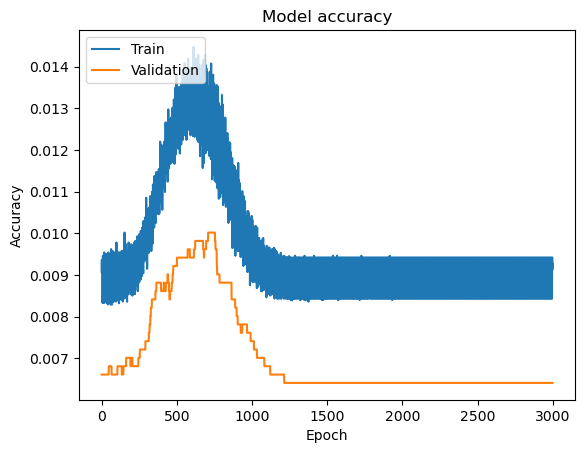

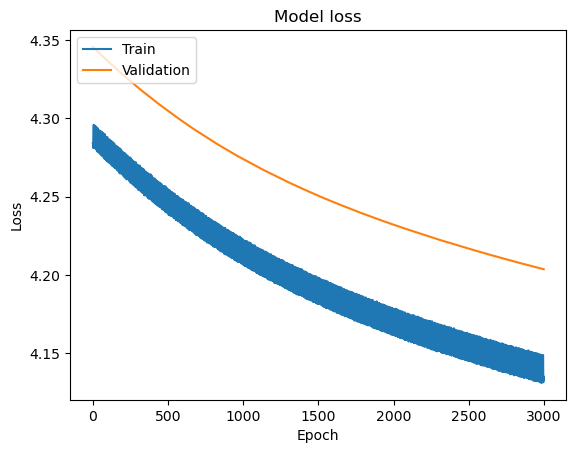

2/2 [==============================] - 1s 7ms/step
Confusion Matrix:
[[   0    0 5670 4836]
 [   0    0    2   32]
 [   0    0    0   34]
 [   0    0    0   34]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00     10506
     Class 1       0.00      0.00      0.00        34
     Class 2       0.00      0.00      0.00        34
     Class 3       0.01      1.00      0.01        34

    accuracy                           0.00     10608
   macro avg       0.00      0.25      0.00     10608
weighted avg       0.00      0.00      0.00     10608



D:\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
# MODEL

# Define the model
def model_gru(num_classes):
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(max_length, padded_videos.shape[2])))  # Masking layer
    model.add(GRU(128, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(GRU(64, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(GRU(32, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))  # Output layer

    return model

def model_lstm(num_classes):
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(max_length, padded_videos.shape[2])))  # Masking layer
    model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer
    
    return model
    

model = model_lstm(num_classes = 4)
optimizer = Adam(learning_rate=1e-5)
# optimizer = SGD(learning_rate=1e-5)

# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", 
                                                                      tf.keras.metrics.AUC(curve="ROC", name="roc_auc",multi_label=False),
                                                                      tf.keras.metrics.AUC(curve="PR", name="pr_auc",multi_label=False)])
model.summary()


# Train model

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
# Set batch size and number of epochs
batch_size, epochs = 32, 3000

train_generator = data_generator(train_videos, y_train, batch_size, class_weights)
val_generator = data_generator(val_videos, y_val, batch_size, class_weights)

history = model.fit(train_generator, steps_per_epoch=len(train_videos) // batch_size, epochs=epochs, 
                    validation_data=val_generator, validation_steps=len(val_videos) // batch_size, 
                    callbacks=[earlystop], verbose=1, shuffle=False)

# Check the training history
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model
y_pred = model.predict(test_videos, batch_size=batch_size)
y_pred_classes = np.argmax(y_pred, axis=-1).reshape(-1)  # Flatten predictions
y_test_classes = np.argmax(y_test, axis=-1).reshape(-1)  # Flatten true labels

# Filter out padding labels (class -1)
valid_indices = y_test_classes != -1
y_pred_classes_filtered = y_pred_classes[valid_indices]
y_test_classes_filtered = y_test_classes[valid_indices]

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_classes_filtered, y_pred_classes_filtered)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test_classes_filtered, y_pred_classes_filtered, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print("Classification Report:")
print(class_report)


2/2 [==============================] - 0s 26ms/step


C:\Users\111064555\AppData\Local\Temp\ipykernel_11544\3335130318.py:40: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


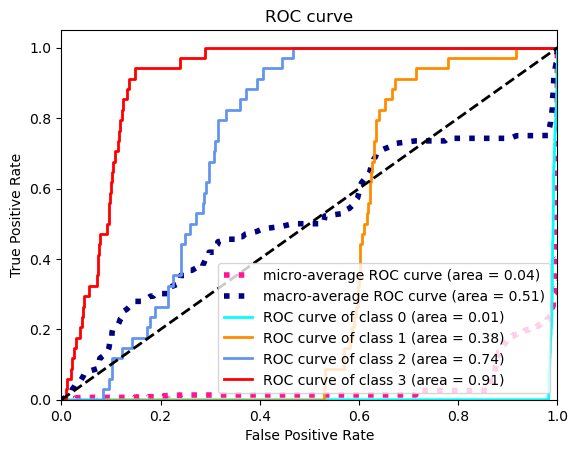

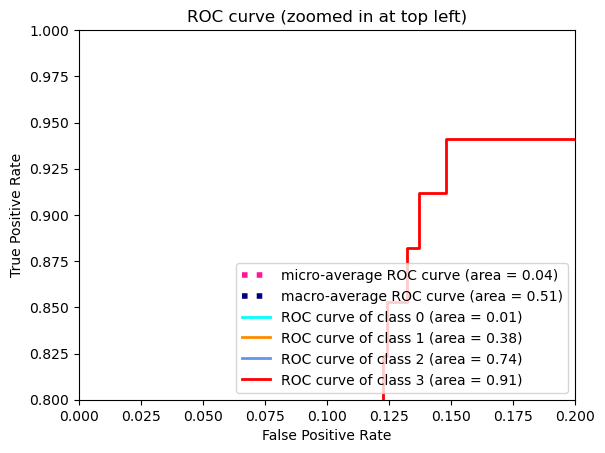

In [70]:
# Plot ROC curve
# Number of classes
n_classes = 4

# Predict the probabilities
y_score = model.predict(test_videos)
# y_score = model.predict(val_videos)

# Ensure y_test and y_score are numpy arrays
y_test_array = np.array(y_test)
# y_test_array = np.array(y_val)
y_score = np.array(y_score)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_array[:, :, i].ravel(), y_score[:, :, i].ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_array.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Zoom in view of the upper left corner
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1.0)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc="lower right")
plt.show()


2/2 [==============================] - 0s 30ms/step
[[   0    0 5670 4836]
 [   0    0    2   32]
 [   0    0    0   34]
 [   0    0    0   34]]
Normalized confusion matrix


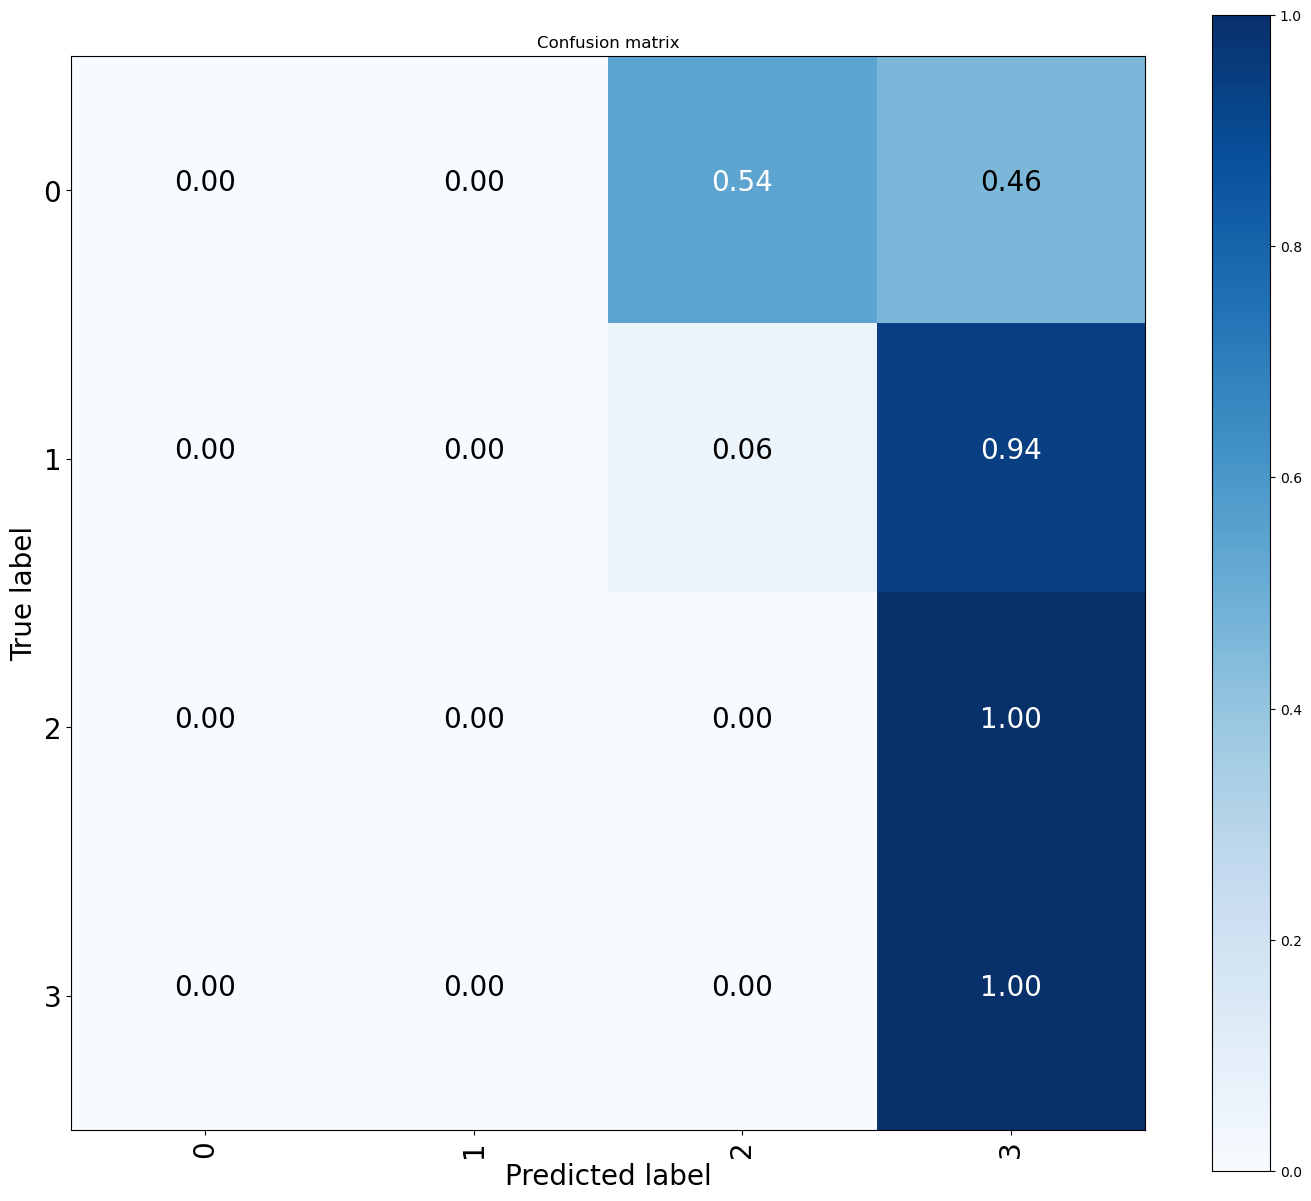

In [72]:
##### Plot confusion matrix

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          text_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=text_size)
    plt.yticks(tick_marks, classes, fontsize=text_size)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=text_size)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=text_size)
    plt.xlabel('Predicted label', fontsize=text_size)


classes = [0,1,2,3]
y_pred = model.predict(test_videos)

y_pred_argmax = np.argmax(y_pred, axis=2)
y_test_argmax = np.argmax(y_test, axis=2)

y_pred_flattened = y_pred_argmax.flatten()
y_test_flattened = y_test_argmax.flatten()

# calculate confusion matrix
cnf_matrix = confusion_matrix(y_test_flattened,y_pred_flattened)
print(cnf_matrix)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, text_size=20)
                      #title='Normalized confusion matrix'

In [37]:
# SAVE MODEL
model.save("D:\\111064555\\Work\\code\\batch_lstm_add1_0609.h5")

## Trial

In [77]:
from tensorflow.keras.models import load_model
model_path = "D:\\111064555\\Work\\code\\\Final_Model\\Model\\batch_gru_add1_0609.h5"
# batch_lstm_add1_0609.h5
# batch_gru_add1_0609.h5
# batch_gru_0609.h5
# batch_lstm_0608.h5
model = load_model(model_path)

In [78]:
# APE

# Read data
file_paths = [
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\half_coordinates_01.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\half_coordinates_02.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\half_coordinates_03.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\half_coordinates_04.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\half_coordinates_05.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\half_coordinates_06.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\half_coordinates_07.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\half_coordinates_08.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\half_coordinates_09.csv',
    r'D:\\111064555\Work\code\datasets\data_trial\Coordinate\half_coordinates_10.csv'
]

# Ground truth
true_positions = [
    [15, 36, 41],
    [56, 62, 68],
    [20, 40, 50],
    [10, 34, 40],
    [26, 45, 51],
    [22, 38, 43],
    [13, 22, 30],
    [14, 29, 40],
    [13, 36, 41],
    [9, 21, 23]
]


max_length = 312
num_features = 45  


videos = []
original_lengths = []
for file_path in file_paths:
    ds_x = pd.read_csv(file_path)
    data_x = ds_x['coordinate'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ', dtype=np.float64))
    data_x = np.stack(data_x.values)
    videos.append(data_x)
    original_lengths.append(len(data_x))

padded_videos = pad_sequences(videos, maxlen=max_length, dtype='float64', padding='post', value=0.0)

# print(f"Shape after padding: {padded_videos.shape}") 
y_pred = model.predict(padded_videos)

keyframes_list = []

for video_pred, original_length in zip(y_pred, original_lengths):
    effective_video_pred = video_pred[:original_length]
    
    keyframe1_candidates = np.argsort(effective_video_pred[:, 1])[::-1]
    keyframe2_candidates = np.argsort(effective_video_pred[:, 2])[::-1]
    keyframe3_candidates = np.argsort(effective_video_pred[:, 3])[::-1]
    
    for idx in keyframe1_candidates:
        if idx < keyframe2_candidates[0] and idx < keyframe3_candidates[0]:
            keyframe1_idx = idx
            break
    for idx in keyframe2_candidates:
        if idx > keyframe1_idx and idx < keyframe3_candidates[0]:
            keyframe2_idx = idx
            break
    for idx in keyframe3_candidates:
        if idx > keyframe1_idx and idx > keyframe2_idx:
            keyframe3_idx = idx
            break
    keyframes_list.append([keyframe1_idx, keyframe2_idx, keyframe3_idx])

# Calculate APE
def average_position_error(pred_positions, true_positions):
    keyframe_errors = []
    for i in range(3):
        errors = [abs(pred[i] - true[i]) for pred, true in zip(pred_positions, true_positions)]
        keyframe_errors.append(np.mean(errors))
    avg = (keyframe_errors[0]+keyframe_errors[1]+keyframe_errors[2])/3
    print("Average Position Errors for Keyframes:", keyframe_errors)
    print("AVG error", avg)

average_position_error(keyframes_list, true_positions)

# Save result
output = pd.DataFrame(keyframes_list, columns=['keyframe1', 'keyframe2', 'keyframe3'])
output.to_csv("lstm_trial_keyframes.csv", index=False, header=True)


Shape after padding: (10, 312, 45)
1/1 [==============================] - 1s 1s/step
Average Position Errors for Keyframes: [6.2, 3.1, 2.6]
AVG error 3.966666666666667
